In [1]:
import torch
import argparse
from torchvision import transforms
from torchsample.transforms import TypeCast, RangeNormalize, RandomAffine
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data_utils
from sklearn.decomposition import PCA
import torch.nn.functional as F
from torch.autograd import Variable
from data_set_api import VAEIcebergDataset
import pandas as pd

In [2]:
CROP_SIZE=64
PCA_ENERGY = .97

In [3]:
def get_data_transforms(is_augment, crop_size=64):
    transform_list = [transforms.ToPILImage(), transforms.CenterCrop(crop_size), transforms.ToTensor()]

    transform_list.append(transforms.Lambda(lambda img: RangeNormalize(0, 1)(TypeCast('float')(img))))

    if is_augment is True:
        rotation_range = 15
        scale_range = None
        translation_range = (-0.1, 0.1) 

        affine_transform = RandomAffine(rotation_range=rotation_range, zoom_range=scale_range, translation_range=translation_range)
        transform_list.append(transforms.Lambda(lambda img: affine_transform(img))) 

    return transforms.Compose(transform_list)

In [4]:
train = pd.read_json('Data/train.json')
test = pd.read_json('Data/test.json')

In [5]:
def get_train_test_data(band='band_1'):
    
    train['band'] = [np.array(img).reshape((75,75)) for img in train[band]]
    print("Train: ", train.shape)
    test['band'] = [np.array(img).reshape((75,75)) for img in test[band]]
    print("Test: ", test.shape)
    
    data_transforms = get_data_transforms(False, CROP_SIZE)

    
    train_dataset = VAEIcebergDataset(
        df=train,
        transform=data_transforms
    )

    train_loader = data_utils.DataLoader(train_dataset,
                               batch_size=1,
                               shuffle=False,
                               num_workers=0)
    
    test_dataset = VAEIcebergDataset(
        df=test,
        transform=data_transforms
    )
    
    test_loader = data_utils.DataLoader(test_dataset,
                               batch_size=1,
                               shuffle=False,
                               num_workers=0)
    return train_loader, test_loader

In [6]:
def create_numpy_dataset(data_loader):
    datasets = []
    for data in data_loader:
        data_numpy = data[0].numpy()
        data_numpy = np.squeeze(data_numpy)
        datasets.append(data_numpy)

    datasets = np.array(datasets)
    print('Shape: ', datasets.shape, end=' => ')
    
    datasets=np.expand_dims(datasets,axis=1)
    print(datasets.shape, ' (new)')
    
    return datasets

In [7]:
'''
@ depth: determine shape, initial: 0
'''
from itertools import product
def fit_pca_shape(datasets,depth):
    factor=np.power(2,depth)
    length=int(CROP_SIZE/factor)
    print('L=', length)
    if length % 2 != 0:
        length -= 1
    idx1=range(0,length,2)
    idx2=[i+2 for i in idx1]
    print(idx2)
    data_lattice=[datasets[:,:,i:j,k:l] for ((i,j),(k,l)) in product(zip(idx1,idx2),zip(idx1,idx2))]
    data_lattice=np.array(data_lattice)
    print('fit_pca_shape: data_lattice.shape: {}'.format(data_lattice.shape))

    #shape reshape
    data=np.reshape(data_lattice,(data_lattice.shape[0]*data_lattice.shape[1],data_lattice.shape[2],2,2))
    print('fit_pca_shape: reshape: {}'.format(data.shape))
    return data

In [8]:
'''
@ Prepare shape changes. 
@ return filters for convolution
@ aug_anchors: [out_num*in_num,4] -> [out_num,in_num,2,2]
'''
def ret_filt_patches(aug_anchors,input_channels):
    shape=int(aug_anchors.shape[1]/4)
    num=aug_anchors.shape[0]
    filt=np.reshape(aug_anchors,(num,shape,4))
    
    # reshape to kernels, (# output_channels,# input_channels,2,2)
    filters=np.reshape(filt,(num,shape,2,2))

    return filters

In [9]:
'''
@ return: augmented anchors
'''
def PCA_and_augment(data_in, n_components=1.0):
    # data reshape
    data=np.reshape(data_in,(data_in.shape[0],-1))
    mean=np.mean(data,axis=0)
    datas_mean_remov = data - mean

    pca=PCA(n_components=n_components)
    datas_mean_remov.astype(np.float64)
    pca.fit(datas_mean_remov)
    comps=pca.components_

    if comps[-1][0]<0:
        for i in comps:
            i*=-1
    comps_aug=[vec*(-1) for vec in comps]
    comps_complete=np.vstack((comps,comps_aug))
    
    return comps_complete,mean

In [10]:
'''
@ input: kernel and data
@ output: conv+relu result
'''
def conv_and_relu(filters,datasets,stride=2):
    # torch data change
    
    filters_t=torch.from_numpy(filters)
    datasets_t=torch.from_numpy(datasets)

    # Variables
    filt=Variable(filters_t).type(torch.FloatTensor)
    data=Variable(datasets_t).type(torch.FloatTensor)

    # Convolution
    output=F.conv2d(data,filt,stride=stride)

    # Relu
    relu_output=F.relu(output)

    return relu_output,filt

In [11]:
'''
@ One-stage Saak transform
@ input: datasets [60000,channel,size,size]
'''
def one_stage_saak_trans(datasets=None, is_train=True, test_filters=None, test_means=None, depth=0):

    if is_train is True:
        print('one_stage_saak_trans: datasets.shape {}'.format(datasets.shape))
        input_channels=datasets.shape[1]

        data_flatten=fit_pca_shape(datasets,depth)

        comps_complete,mean=PCA_and_augment(data_flatten, PCA_ENERGY)
        print(comps_complete.shape, mean.shape)

        filters=ret_filt_patches(comps_complete,input_channels)
        print('one_stage_saak_trans: filters: {}'.format(filters.shape))

        mean = np.mean(datasets,axis=0)
    else:
        filters = test_filters[depth].data.numpy()
        mean = test_means[depth]
        
    datasets-=mean
    relu_output,filt=conv_and_relu(filters,datasets,stride=2)
    res=relu_output.data.numpy()
    
    print('one_stage_saak_trans final.shape: {}'.format(res.shape))

    return Variable(torch.from_numpy(res)), filt, res, mean

In [12]:
'''
@ Multi-stage Saak transform
'''
def multi_stage_saak_trans(data_loader, is_train=True, test_means=None, test_filters=None):
    filters = []
    outputs = []
    means=[]
    
    data=create_numpy_dataset(data_loader)
    dataset=np.copy(data)
    num=0
    img_len=data.shape[-1]
    while(img_len>=2):
        num+=1
        img_len/=2

    for i in range(num):
        print('{} stage of saak transform: '.format(i+1))
        
        output, filt, data, mean=one_stage_saak_trans( data, is_train, 
                                                       test_means=test_means,
                                                       test_filters=test_filters, 
                                                       depth=i )
        outputs.append(output)
        filters.append(filt)
        means.append(mean)
        
        print('')

    return outputs, filters, means, dataset

In [13]:
def process_intermediate_result(result, middle_output, prefix):
    print(result.shape)
    for stage in range(len(middle_output)):
        features = middle_output[stage] # ex: 1604, 6, 32, 32 (tensor)
        features = features.data.numpy()
        features = features.reshape((features.shape[0],features.shape[1]*features.shape[2]*features.shape[3]))
        
        f_names = [(prefix + "_st_" + str(stage) + '_f_' + str(fn)) for fn in range(features.shape[1])]
        middle = pd.DataFrame(data=features, columns=f_names)
        
        result = pd.concat([result, middle], axis=1)
        print(result.shape)
    return result

In [14]:
# show sample
def show_sample(ori,rec):
    fig = plt.figure(1,figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.set_title('Original')
    ax.imshow(ori, cmap='gray')
    
    ax = fig.add_subplot(1,2,2)
    ax.set_title('Reconstructed')
    ax.imshow(rec, cmap='gray')
    
    plt.show()

In [15]:
import numpy as np

def psnr(im1,im2):
    diff =(im1 - im2)
    diff=diff**2
    rmse=np.sqrt(diff.sum())
    psnr = 20*np.log10(1/rmse)
    return psnr

In [16]:
'''
@ Reconstruct from second-last stage
@ In fact, can be from any stage
'''
def toy_recon(outputs,filters,means, start=0):
    outputs=outputs[::-1][start:]
    filters=filters[::-1][start:]
    means=means[::-1][start:]
    num=len(outputs)
    data=outputs[0]
    for i in range(num):
        data = F.conv_transpose2d(data, filters[i], stride=2)
        data+=Variable(torch.from_numpy(means[i]))
    return data

Processing band_1
Train:  (1604, 6)
Test:  (8424, 5)
Shape:  (1604, 64, 64) => (1604, 1, 64, 64)  (new)
1 stage of saak transform: 
one_stage_saak_trans: datasets.shape (1604, 1, 64, 64)
L= 64
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
fit_pca_shape: data_lattice.shape: (1024, 1604, 1, 2, 2)
fit_pca_shape: reshape: (1642496, 1, 2, 2)
(6, 4) (4,)
one_stage_saak_trans: filters: (6, 1, 2, 2)
one_stage_saak_trans final.shape: (1604, 6, 32, 32)

2 stage of saak transform: 
one_stage_saak_trans: datasets.shape (1604, 6, 32, 32)
L= 32
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
fit_pca_shape: data_lattice.shape: (256, 1604, 6, 2, 2)
fit_pca_shape: reshape: (410624, 6, 2, 2)
(36, 24) (24,)
one_stage_saak_trans: filters: (36, 6, 2, 2)
one_stage_saak_trans final.shape: (1604, 36, 16, 16)

3 stage of saak transform: 
one_stage_saak_trans: datasets.shape (1604, 36, 16, 16)
L= 16
[2, 4, 6, 8, 10, 12, 

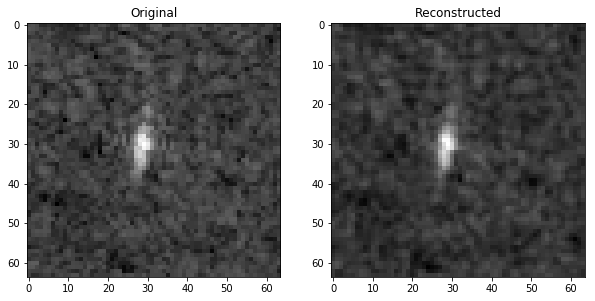

psnr metric: -7.061751206242899


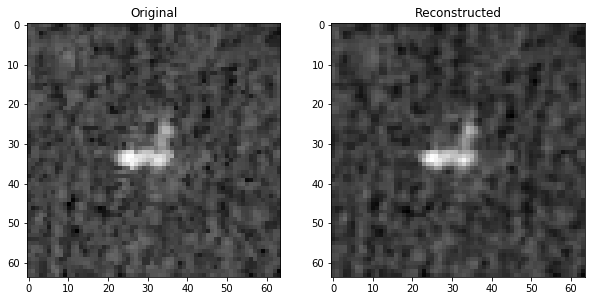

psnr metric: -5.282159511091602


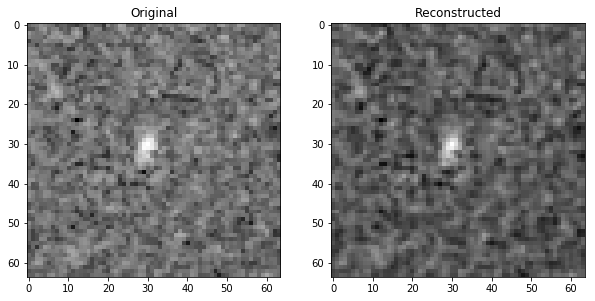

psnr metric: -7.75752610062886


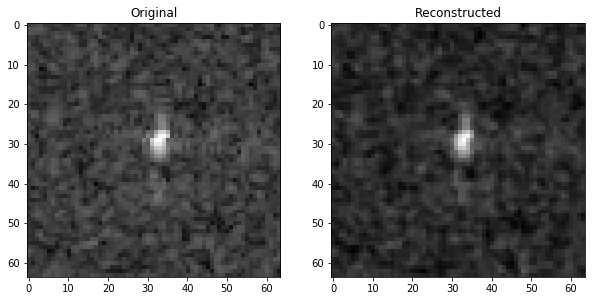

psnr metric: -6.372905274192546


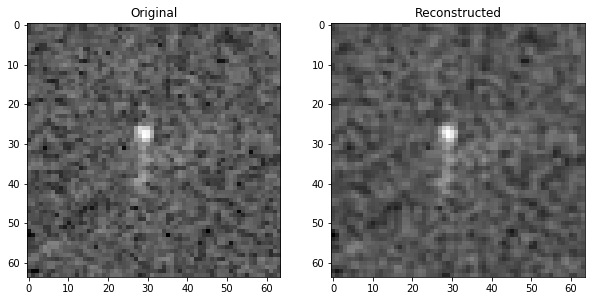

psnr metric: -7.988805004400286


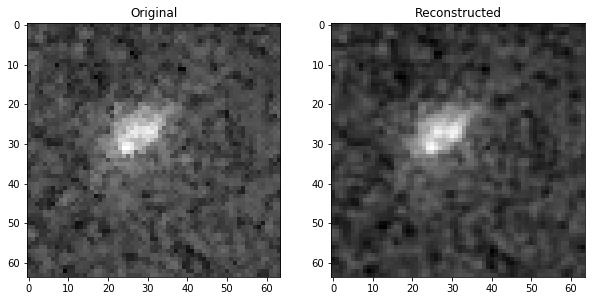

psnr metric: -6.75798014423264


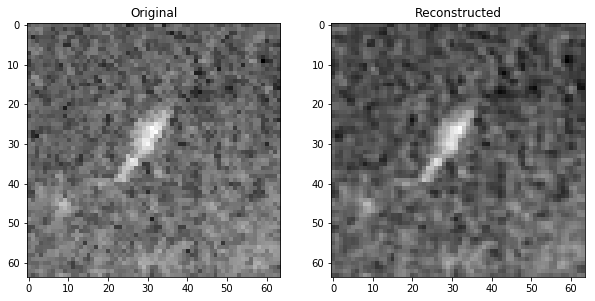

psnr metric: -7.917246107486173


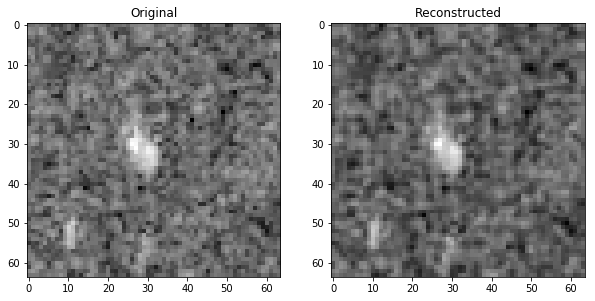

psnr metric: -7.730958785078852


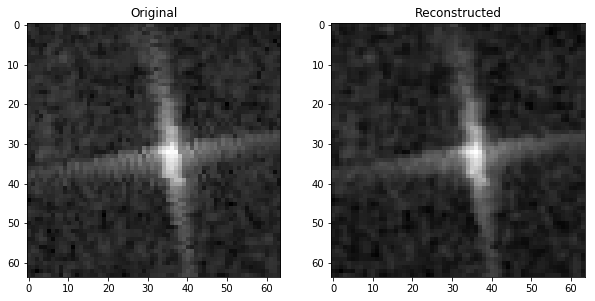

psnr metric: -4.0546627341617985


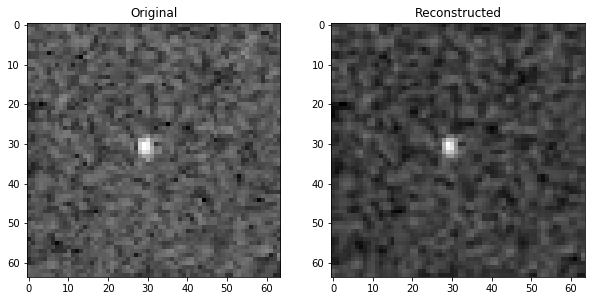

psnr metric: -7.622330787257599


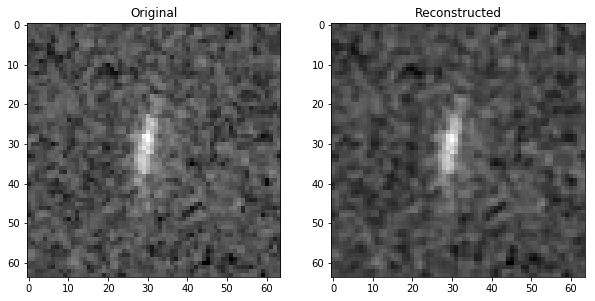

psnr metric: -6.937706897354403


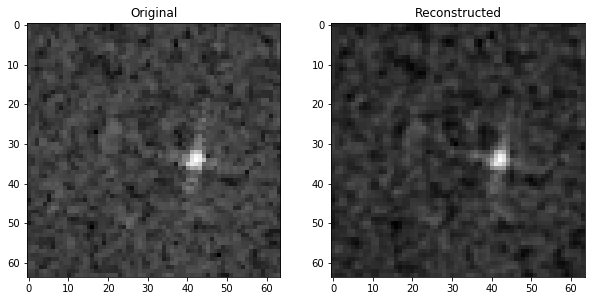

psnr metric: -6.077246918628187


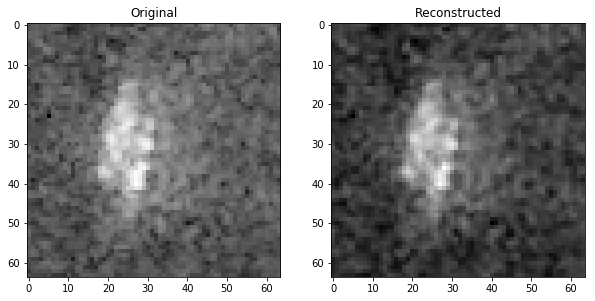

psnr metric: -4.807660261659573


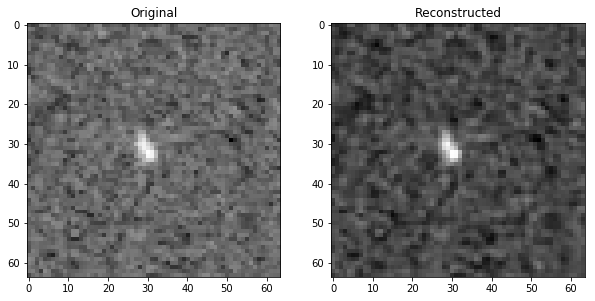

psnr metric: -7.813013919781852


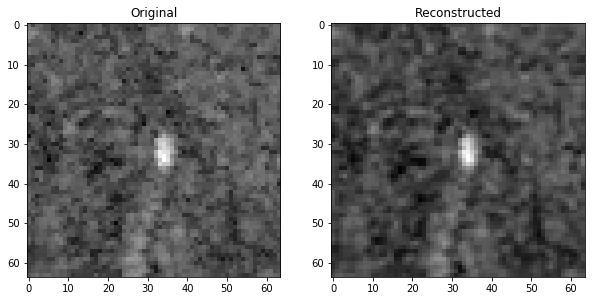

psnr metric: -6.502281220781732


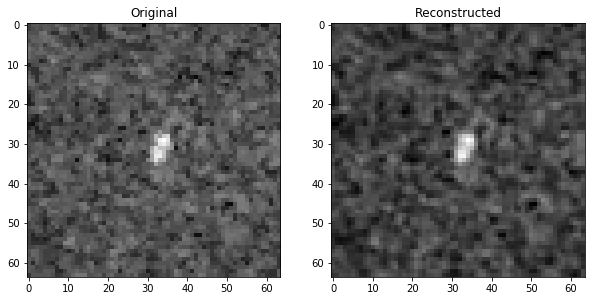

psnr metric: -7.425520561773411


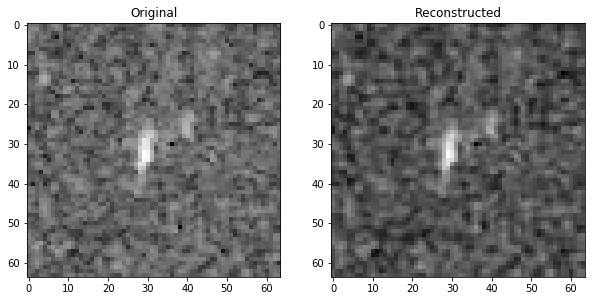

psnr metric: -6.950511848162172


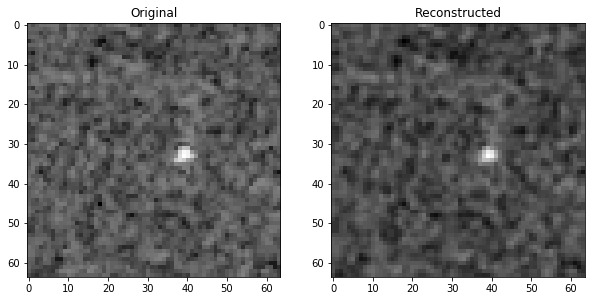

psnr metric: -6.336901419385121


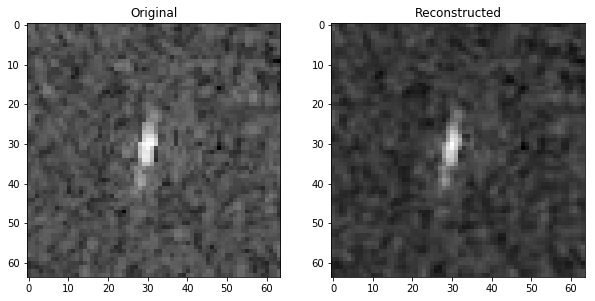

psnr metric: -7.341641471857362


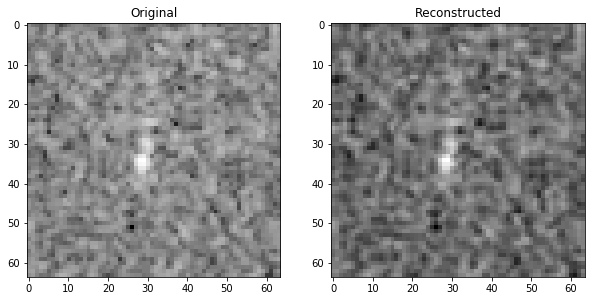

psnr metric: -5.747873472688156
Test recontructed


KeyboardInterrupt: 

In [17]:
import gc
train_result = pd.DataFrame()
test_result = pd.DataFrame()
train_result['is_iceberg'] = train['is_iceberg']
test_result['is_iceberg'] = np.zeros((test.shape[0],))

for band in ['band_1', 'band_2']:
    print("Processing " + band)
    train_data_loader, test_data_loader = get_train_test_data('band_1')
    
    train_outputs, filters, means, train_data = multi_stage_saak_trans(train_data_loader)
    test_outputs, _, _, test_data = multi_stage_saak_trans(test_data_loader, is_train=False, test_means=means, test_filters=filters)
    
    train_result = process_intermediate_result(train_result, train_outputs, prefix=band)
    test_result = process_intermediate_result(test_result, test_outputs, prefix=band)
    
    print("Train recontructed")
    ret=toy_recon(train_outputs, filters,means, start=0)
    for i in range(20): 
        inv_img=ret.data.numpy()[i][0]
        show_sample(train_data[i][0],inv_img)
        print('psnr metric: {}'.format(psnr(train_data[i][0],inv_img)))
    
    print("Test recontructed")
    ret=toy_recon(test_outputs, filters, means, start=0)
    for i in range(20): 
        inv_img=ret.data.numpy()[i][0]
        show_sample(test_data[i][0],inv_img)
        print('psnr metric: {}'.format(psnr(test_data[i][0],inv_img)))
        
    del train_data_loader, test_data_loader
    gc.collect()
    
train_result.to_csv("Data/saak_transformed_train_energy_90.csv", index=False, float_format="%.15f")
test_result.to_csv("Data/saak_transformed_test_energy_90.csv", index=False, float_format="%.15f")